This notebook is used for exploring different loss functions

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np

from scipy import signal
from scipy.signal import stft
from scipy.io import wavfile

import matplotlib.pyplot as plt

import torch

from visualization import plot_spec

981.8088030661817


""


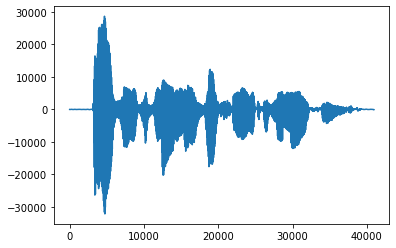

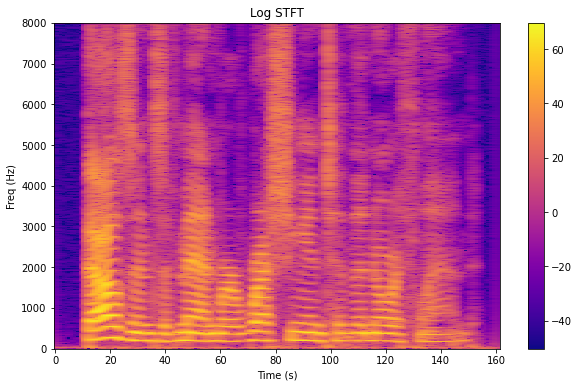

In [11]:
from scipy.fft import dct
from data import read_audio
from data.transform import db_to_amp
from data.metadata import vcc

def log_stft(amp, dynamic_range=120):
    """
    :param amp: amplitude
    :param dynamic_range: in db
    :return: time (1D array), frequencies (1D array), log amplitude
        log_amp is (num_freq, num_time) numpy array, in decibels

    Note on dynamic_range:
    -------
    Assuming that the weakest detectable sound is 0 db, then the loudest
    possible sound is 194 db.

    db = 20 * log_10(amp)
    """
    max_amp = np.max(amp)
    if max_amp == 0:
        return amp
    log_amp = 20 * np.log10(
        np.clip(amp, max_amp / db_to_amp(dynamic_range), np.inf))
    return log_amp


sr, dat = wavfile.read(vcc.train_2016(0, 2))
print(np.average(dat**2))

plt.figure()
plt.plot(dat)


def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))


sound(dat)


def filter(log_amp, filter_size=10):
    if len(log_amp.shape) == 1:
        kernel = np.ones(filter_size) / filter_size
    else:
        kernel = np.ones((filter_size, 1)) / filter_size
    return signal.convolve(log_amp, kernel, mode='same')


N_FFT = 2048
freq, time, zxx = stft(dat, sr, nperseg=N_FFT, noverlap=N_FFT-256)
amp = np.abs(zxx)
log_amp = log_stft(amp)
plot_spec(log_amp, freq=freq, title='Log STFT')

# from data.transform import mfcc_from_amp
# mfcc = mfcc_from_amp(amp, sr, n_mfcc=20)
# plot_spec(mfcc, title='MFCC')

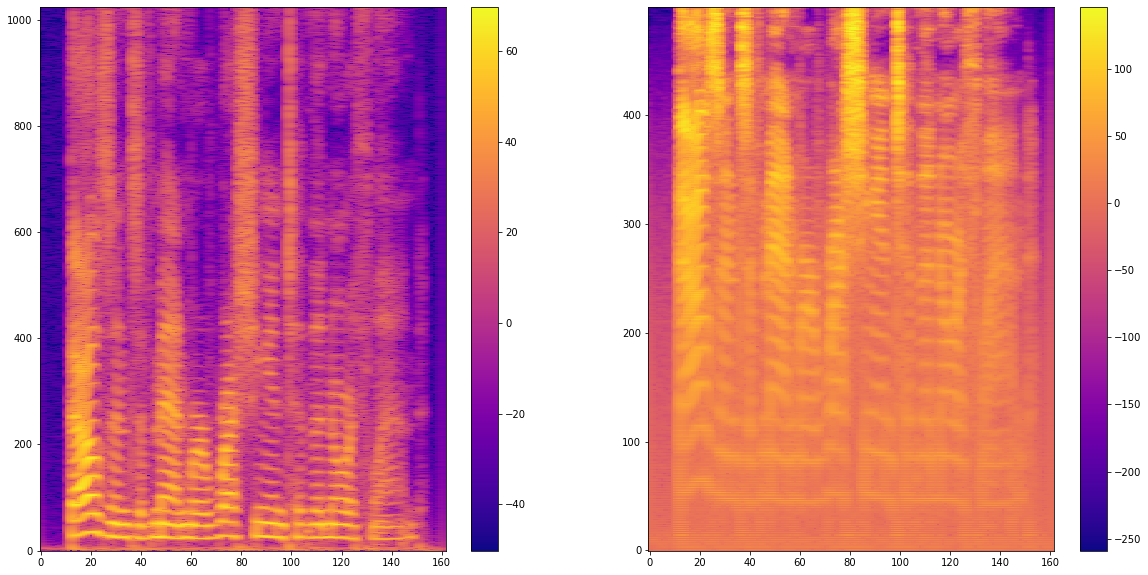

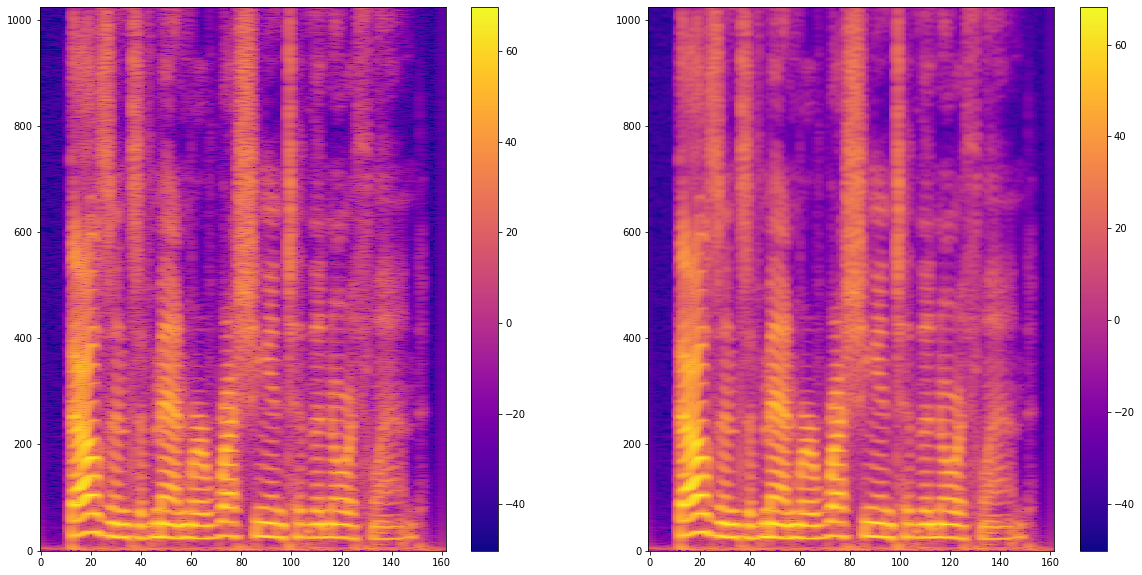

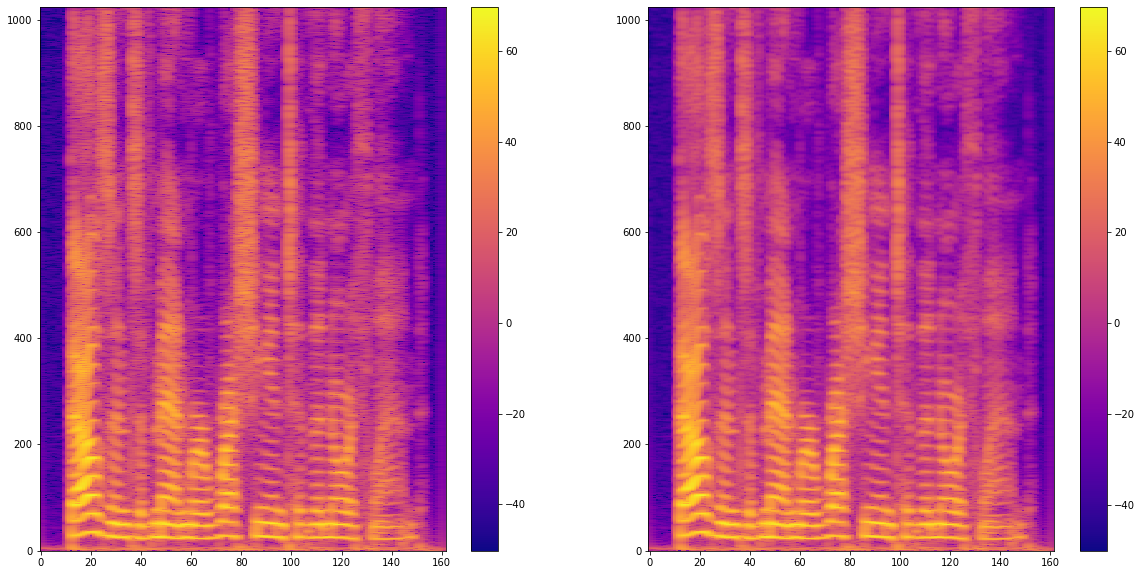

In [25]:

def plot_spec_torch(spec, title, *args, **kwargs):
    plt.figure(figsize=(20,10))
    plt.title(title)
    plt.subplot(1,2,1)
    plot_spec(log_amp, figure_size=(10,10), new_plot=False)
    plt.subplot(1,2,2)
    plot_spec(spec.detach(). numpy(), *args,
              figure_size=(10,10), new_plot=False, **kwargs)

from loss import MelMSE, MelMeanFilteredMSE, MelGaussianFilteredMSE
from loss import *

mel_mse = MelMSE(n_mel=500, is_input_log_amp=True)
plot_spec_torch(mel_mse.mel(torch.from_numpy(log_amp)), title='Mel spec')

mel_filtered_mse = MelMeanFilteredMSE(max_filter_size=5)
plot_spec_torch(mel_filtered_mse.transform(torch.from_numpy(log_amp)),
          title='Mel spec mean')

mel_filtered_mse = MelGaussianFilteredMSE(max_filter_size=10)
plot_spec_torch(mel_filtered_mse.transform(torch.from_numpy(log_amp)),
          title='Mel spec gaussian')

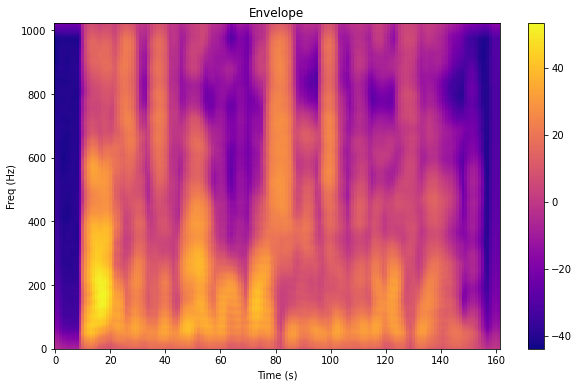

In [4]:
envelope = filter(log_amp, filter_size=100)

plot_spec(envelope, title='Envelope')

In [5]:
# import data.transform.cepstrum as cepstrum
#
# mod_ceps = cepstrum.mod_cepstrum(log_amp, filter_size=20)
#
# plot_spec(np.sqrt(mod_ceps)[:256],freq=freq[:256],
#           title='Mod ceps filter=?')
#
# fundamental = np.argmax(mod_ceps, axis=0)
#
# plot_spec(log_amp, freq=freq, title='STFT', figure_size=(10,10))
# for i in range(1, 5):
#     plt.plot(np.arange(log_amp.shape[1]), i*freq[fundamental])



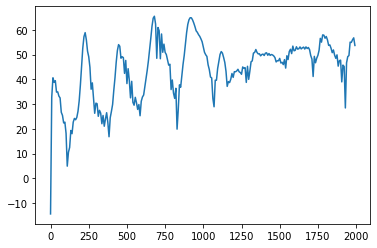

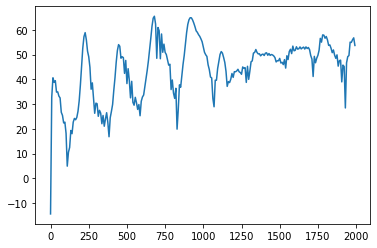

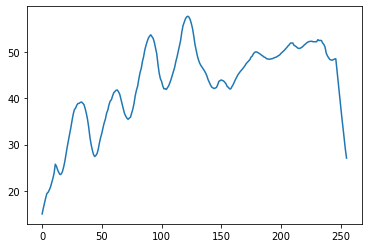

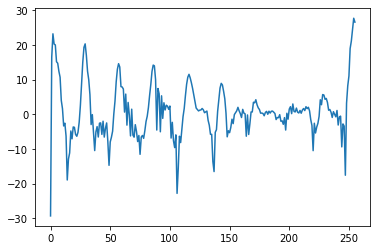

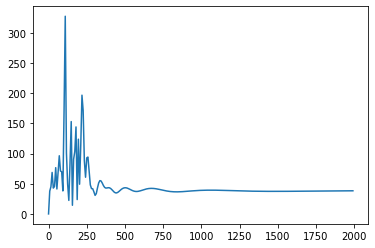

In [6]:

from numpy.fft import fft, rfft
from scipy.signal import convolve

from data.transform import cepstrum

t = 15
plt.figure()
frame = log_amp[:,t]

fn=freq.size//4
plt.plot(freq[:fn], frame[:fn])

def analyze(freq, frame):
    plt.figure()
    plt.plot(freq, frame)
    filter_size = 20
    low_pass_filtered = convolve(frame, np.ones(filter_size)/filter_size, mode='same')
    hi_pass_filtered = frame - low_pass_filtered

    plt.figure()
    plt.plot(low_pass_filtered)
    plt.figure()
    plt.plot(hi_pass_filtered)

    plt.figure()
    mod_ceps = np.abs(cepstrum.mod_cepstrum(hi_pass_filtered))
    mod_ceps[0] = 0
    plt.plot(freq[:fn], mod_ceps)


analyze(freq[:fn], frame[:fn])


(1025, 162)


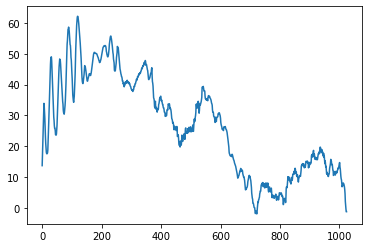

In [7]:
low_pass_filtered = convolve(log_amp, np.ones((10, 1))/10, mode='same')
print(low_pass_filtered.shape)
plt.figure()
plt.plot(low_pass_filtered[:,t])

In [8]:
# from IPython import display
# from ipywidgets import widgets
#
# colorpicker = widgets.ColorPicker(
#     concise=False,
#     description='Pick a color',
#     value='black',
#     disabled=False
# )
# display.display(colorpicker)

In [9]:
# from IPython.core.display import Javascript
#
# color = colorpicker.value
# Javascript("""
# let div = document.getElementById('color');
# document.body.style.backgroundColor = "{}";
# """.format(color))
#